## Math genealogy

This is a website document mathematicians, their advisors and their students:

http://www.genealogy.ams.org

We start with webscraping the data, see the scraping python script I wrote. It scraped about 60000 pages in about 10 hours, however there was some formatting errors. Below I have used approximately the first 17000 entries from the genealogy project, those missing are the result of formatting and web scraping errors.

In [9]:

import pandas as pd
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import sklearn.cluster
import sklearn.ensemble

In [65]:
# read in the csv data
mathematicians = pd.read_csv('data/math_data.csv', delimiter=',')

# take only those rows with a numeric mathId (the scraping went bad at some points)
mathematicians = mathematicians[mathematicians.mathId.apply(lambda x: x.isnumeric())].set_index('mathId')

In [66]:
# add a row for numeric year
years = mathematicians.thesisYear.apply(pd.to_numeric, errors='coerce')
# some of the years were doubled up, eg 19771984. Fix in those cases:
for idx in years[years > 10000].index:
    years[idx] = float(int(years[idx]/10000))
# add a column to the dataframe with numeric years
mathematicians['numericYear'] = years
# filter out some obvious bad ones, this might be throwing out a bunch of my data...
mathematicians = mathematicians[(mathematicians.numericYear.isnull() == False)
                               & (mathematicians.numericYear > 1000)]

In [67]:
names = ['Leonhard  Euler', 'Carl Friedrich GauÃ\x9f']
mathematicians[mathematicians.name=='Leonhard  Euler']

,name,advisors,thesis,thesisUniversity,thesisCountry,thesisYear,numStudents,numDescendants,numericYear
mathId,,,,,,,,,
38586,Leonhard Euler,Johann Bernoulli,Dissertatio physica de sono,Universität Basel,Switzerland,1726,6.0,95046.0,1726.0


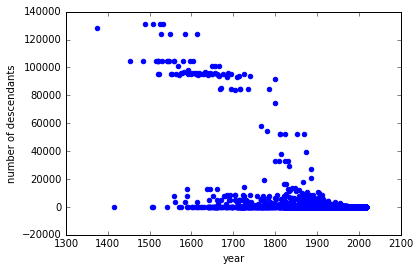

In [68]:
# a plot of year vs number of descendants
#
# as you would expect, there are several old mathematicians with huge numbers of descendants
x = mathematicians.numericYear
y = mathematicians.numDescendants
plt.scatter(x,y, color='blue')
plt.xlabel('year')
plt.ylabel('number of descendants')

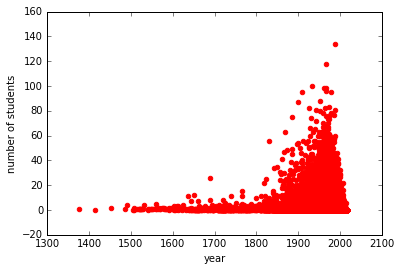

In [70]:
# a plot of the when a mathematician did their thesis against the number of students they have had
#
# the graph makes sense because those who recently earned a PhD are unlikely to have many students,
# while those who earned one a long time ago are unlikely to have many students because there weren't many students in 
# general back then.

x = mathematicians.numericYear
y = mathematicians.numStudents
plt.scatter(x,y, color='red')
plt.xlabel('year')
plt.ylabel('number of students')

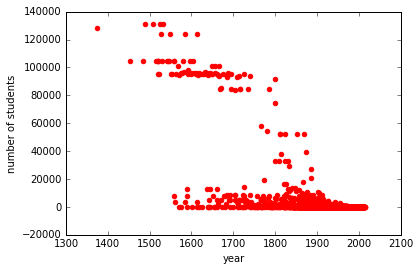

In [72]:
# same plot as above, but remove those with 0 descendants
base_stuff = mathematicians[(mathematicians.numDescendants > 0)
                           & (mathematicians.numStudents > 0)]
x = base_stuff.numericYear
y = base_stuff.numDescendants
plt.scatter(x,y, color='red')
plt.xlabel('year')
plt.ylabel('number of students')

#mathematicians[mathematicians.numStudents > 0].numeric

In [77]:
x = mathematicians[mathematicians.numericYear.isnull() == False]

In [82]:
clusterer = sklearn.cluster.KMeans(init='k-means++', n_clusters=6)

In [83]:
# restruct to those mathematicians with more than 0 students and valid numeric Year
interesting_columns = mathematicians[mathematicians.numStudents > 0][['numStudents', 'numDescendants', 'numericYear']]
X = interesting_columns[['numStudents', 'numDescendants']]

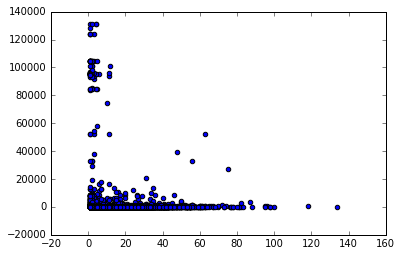

In [84]:
plt.scatter(X.numStudents, X.numDescendants)

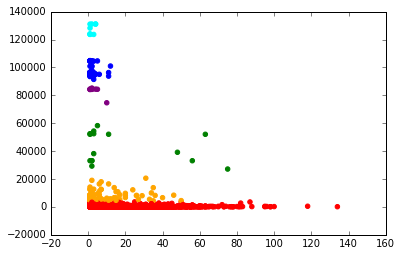

In [85]:

two_clustering = clusterer.fit_predict(X)
rainbow = np.array(['red','blue','green','orange','purple','cyan','teal'])
plt.scatter(X.numStudents, X.numDescendants, 
            color=rainbow[two_clustering])

# this is a little surprising because the x-axis has 0 to 100 scale and y-axis has 0 to 120000

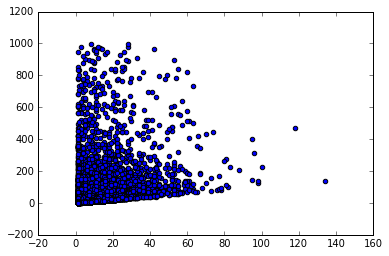

In [92]:
x= mathematicians[(mathematicians.numDescendants < 1000) & (mathematicians.numStudents>0)]
plt.scatter(x.numStudents, x.numDescendants)

In [86]:
X = interesting_columns[['numStudents','numericYear']]
y = interesting_columns.numDescendants

In [87]:
# try training a random forest to predict the number of descendants of a mathematicians based on their
# year of thesis and number of students
rf = sklearn.ensemble.RandomForestRegressor(n_jobs=-1, n_estimators=100)

In [88]:
rf.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

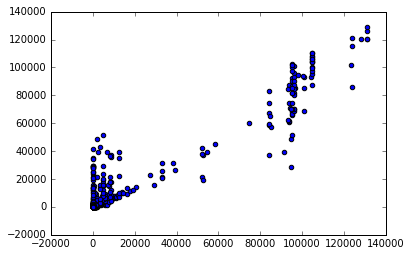

In [89]:
plt.scatter(y, rf.predict(X))